In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Introduction to Hugging Face
Hugging Face is a company that provides open-source tools for machine learning applications. 
Their Transformers library contains implementations of pre-trained transformer models for text, image, and audio tasks. These models that can be further fine-tuned for specific tasks.

## Installation of Required Libraries
To use this notebook, we will need the following libraries

`pip install transformers datasets evaluate accelerate -q`

`pip install torch -q`

`pip install torchvision -q`

# Image Similarity

We will start with an image similarity task, where the goal is to determine how similar two images are, based on their features, content, structure, and so on.

The results can be used in many practical applications, from finding duplicate images in large databases, to categorizing objects in images and detecting street signs, for example.


## Dimensionality reduction with embeddings

Raw images are high-dimensional data, which can lead to several issues. First, the high dimensionality increases the computational complexity, making it difficult to process and analyze the data efficiently. Second, raw images often contain a lot of redundant and irrelevant information, such as background noise, which can negatively impact the performance of machine learning models. Third, the high dimensionality can lead to the curse of dimensionality, where the distance between data points becomes less meaningful, making it harder for algorithms to find patterns and make accurate predictions. 

Image embedding is the process of converting images into a fixed-size vector of numbers (and therefore reducing the dimensionality of images). This vector representation captures the essential features of the image, such as shapes, colors, and textures, in a way that can be easily processed by machine learning algorithms, for example in clustering and classification tasks.

Overall, image embeddings are a powerful tool in data mining, enabling more efficient and effective analysis of visual data.

## Loading a pre-trained model

We will use the `AutoModel` class to interact with the Hugging Face Hub, from where we will load model checkpoints and data processors.

In the following examples we will use the `beans` dataset, so we can use the checkpoint, that was obtained by fine-tuning the model on the same dataset.

In [2]:
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size

c:\Users\Gomis\anaconda3\envs\PRvaje\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Loading the image dataset

We will load the beans leaf dataset from the Hugging Face Hub. The dataset is split into three categories. There are 1034 exaples in the train split, 133 in validation, and 128 in the test split.

In [3]:
from datasets import load_dataset

dataset = load_dataset("beans")

The dataset is comprised of three columns (features):

In [4]:
dataset["train"].features

{'image_file_path': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'labels': ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)}

The dataset contains images of diseased and healthy leaves. Each example falls under one of three classes. Let's check the available classes in the dataset. 

In [5]:
labels_ids = dataset["train"].features["labels"].names
for label in labels_ids:
    print(label)

angular_leaf_spot
bean_rust
healthy


We can also check out an example from each class.

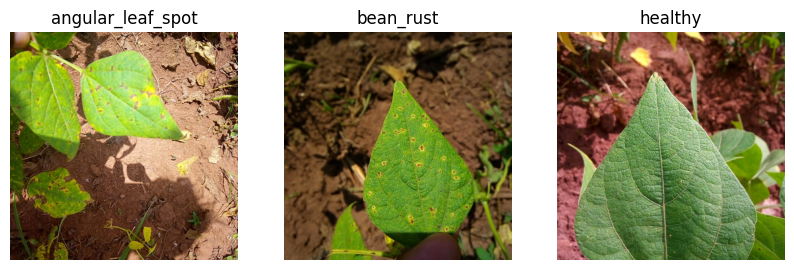

In [6]:
plt.figure(figsize=(10, 5))
for i, img in enumerate([0,350,700]):
    plt.subplot(1, 3, i+1)
    image = dataset["train"][img]["image"]
    plt.imshow(image)
    plt.title(labels_ids[dataset["train"][img]["labels"]])
    plt.axis('off')

## Finding similar images

The process of finding similar images (and their classes) consists of the following steps:

* create embeddings of the images in the `train` split (images with known class)
* create an embedding of an image we want to classify (image without known class)
* calculate the similarity between the image we want to classify and each image we known the class of
* sort the results by similarity and return `n` top similar classes

For this demonstration, we will use only a subset of the `train` data, to keep the computation runtime short.

In [7]:
num_samples = 100
seed = 42
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))


### Data transformation chain

We first resize the input image to 256x256 and then we take center crop.

`transformation_chain` is a compostion of preprocessing transformations we apply to the input images to prepare them for the model. 

In [8]:
import torchvision.transforms as T

transformation_chain = T.Compose(
    [
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

### Calculate embeddings

Utility to compute embeddings

In [9]:
import torch 

def extract_embeddings(model: torch.nn.Module):
    device = model.device

    def pp(batch):
        images = batch["image"]
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp

We map the embedding extraction utility on our subset of candidate images.

In [10]:
batch_size = 25
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=batch_size)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

When the embedding extraction utility has finished, we can check that each image has a new feature.

In [11]:
candidate_subset_emb

Dataset({
    features: ['image_file_path', 'image', 'labels', 'embeddings'],
    num_rows: 100
})

We can check the values of the `embeddings` feature.

In [12]:
candidate_subset_emb[0]["embeddings"]

[-0.037386205047369,
 0.045512400567531586,
 -0.03204941004514694,
 0.047062233090400696,
 -0.2773593068122864,
 -0.06901773810386658,
 -0.19744634628295898,
 -0.17642998695373535,
 -0.22798851132392883,
 0.3825634717941284,
 0.22130852937698364,
 0.050020843744277954,
 -0.27805188298225403,
 -0.13712133467197418,
 -0.010902967303991318,
 -0.206212118268013,
 -0.3517914414405823,
 0.028080077841877937,
 -0.41458040475845337,
 -0.05377943813800812,
 -0.0014988937182351947,
 0.1694941222667694,
 0.5814266800880432,
 0.13074101507663727,
 0.014455695636570454,
 -0.2728566825389862,
 0.04048987478017807,
 -0.0038808919489383698,
 0.14781467616558075,
 -0.19842687249183655,
 -0.05447155982255936,
 -0.2874145209789276,
 0.14431644976139069,
 -0.11574653536081314,
 -0.29012900590896606,
 -0.11584566533565521,
 -0.026377582922577858,
 0.16844961047172546,
 -0.019374294206500053,
 -0.3171597719192505,
 -0.10594753921031952,
 -0.1702842265367508,
 -0.5409887433052063,
 0.016639288514852524,
 -0.

For convenience, we create a list containing the identifiers of the candidate images.

In [13]:
from tqdm.auto import tqdm

candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["labels"]

    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)

    candidate_ids.append(entry)


  0%|          | 0/100 [00:00<?, ?it/s]

### Calculate the similarity

We gather all the embeddings together and store them in a matrix that we can use in the next steps.

In [14]:
all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

A function to compute cosine similarity between two vectors.

In [15]:
def compute_scores(emb_one, emb_two):
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()

The utility function to fetch the `top_k` similar images with `image` as the query.
* Prepare the input query image for embedding computation
* Compute the embedding
* Compute similarity scores with all the candidate images at one go
* Create a mapping between the candidate image identifiers and their similarity scores with the query image
* Sort the mapping dictionary and return `top_k` candidates.

In [16]:
def fetch_similar(image, top_k=5):
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))
 
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    return ids, labels


### Querying the model

Now we can finally perform a query and try to classify an image from the `test` split of the dataset.

In [17]:
test_sample = dataset["test"][0]["image"]
test_label = dataset["test"][0]["labels"]

sim_ids, sim_labels = fetch_similar(test_sample)
print(f"Query label: {test_label}")
print(f"Top 5 candidate labels: {sim_labels}")

Query label: 0
Top 5 candidate labels: [0, 0, 0, 0, 0]


We can see that the label of the query image is the same as the labels of the most similar images.

Let's also visually compare the query image to the most similar ones.

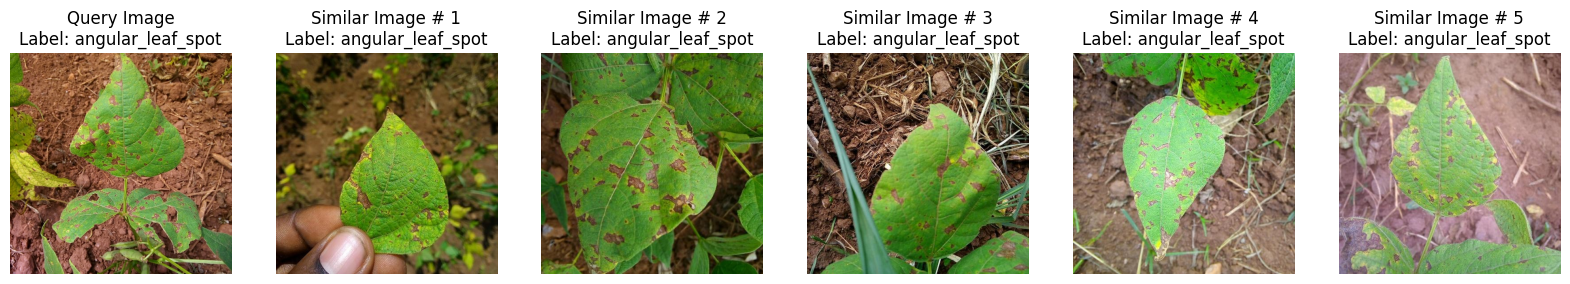

In [18]:
def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(len(images) // columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(labels_ids[label_id]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(labels_ids[label_id])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")

images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["labels"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)

# Text Classification

Text classification is a fundamental task in machine learning where the goal is to assign predefined categories or labels to text documents. This task can be applied to various applications such as sentiment analysis, spam detection, topic labeling, and more. Overall, text classification is a powerful tool for automatically organizing and categorizing large volumes of text data, enabling more efficient and effective analysis.

## Loading the IMDb dataset

We will load the IMDb dataset from Hugging Face. 

In [19]:
imdb = load_dataset("imdb")

Let's start by first checking out how the dataset is structured.

In [20]:
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

We can see that each example consists of some text (the movie review) and a label. Let's check the values of the labels.

In [21]:
for label in imdb["train"].features["label"].names:
    print(label)

neg
pos


Let's save this information in a dictionary for later.

In [22]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

We can see that the reviews are classified as either negative or positive.

Let's check out an example from each class.

In [23]:
for text in [100,13000]:
    sentiment= id2label[imdb["train"][text]["label"]]
    print(sentiment + ": " + imdb["train"][text]["text"])

NEGATIVE: Terrible movie. Nuff Said.<br /><br />These Lines are Just Filler. The movie was bad. Why I have to expand on that I don't know. This is already a waste of my time. I just wanted to warn others. Avoid this movie. The acting sucks and the writing is just moronic. Bad in every way. The only nice thing about the movie are Deniz Akkaya's breasts. Even that was ruined though by a terrible and unneeded rape scene. The movie is a poorly contrived and totally unbelievable piece of garbage.<br /><br />OK now I am just going to rag on IMDb for this stupid rule of 10 lines of text minimum. First I waste my time watching this offal. Then feeling compelled to warn others I create an account with IMDb only to discover that I have to write a friggen essay on the film just to express how bad I think it is. Totally unnecessary.
POSITIVE: Visually stunning and full of Eastern Philosophy, this amazing martial arts fantasy is brought to you by master director Tsui Hark, the man behind some of th

## Loading a pre-trained model

Similar to before, we can load and use a model that was pre-trained for text classification and stored on the Hugging Face Hub. Without providing a model, the Hub will return a default model for the specified task. If we add `top_k=None` to the arguments, the model will return the confidence for each class.

In [24]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", top_k=None)
classifier(imdb["test"][150]["text"])

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


[[{'label': 'NEGATIVE', 'score': 0.9996529817581177},
  {'label': 'POSITIVE', 'score': 0.00034699076786637306}]]

Let's try the model on five random reviews.

In [25]:
for review in imdb["test"].shuffle(seed=8).select(range(5)):
    text = review["text"]
    sentiment = review["label"]
    prediction = classifier(text)[0][0]
    print(review["text"][:500]+"...")
    print("Actual sentiment: " + id2label[sentiment])
    print("Predicted sentiment: " + prediction["label"])
    print("Confidence: %.3f" % prediction["score"])
    print("----------")

I had a different experience with this movie - it never got charming, or delightful, or funny for me. one big clue that this was not your typical movie was that the label gave no indication of the Ianguage(s) spoken in the film. another was the lack of choices re subtitles.<br /><br />I found the lack of dialogue annoying, especially when accompanied by exaggerated facial expressions as it almost always was. The wildly inconsistent development of the feeble plot was puzzling. Were there characte...
Actual sentiment: NEGATIVE
Predicted sentiment: NEGATIVE
Confidence: 1.000
----------
The best so-bad-it's-good movie ever made. Rudy Ray Moore is my personal hero. Whether dealing with day to day life or pimping ho's down the block, I can always look to him for inspiration and guidance. When it comes to blaxploitation, Rudy's the man. Nobody is meaner. Watch Dolemite as he and his army of all-female kung fu killers take down Mr. Big and Willie Green. Awesome plot, huh? There are so many one

## Creating own models

We will use our data to fine-tune this model. But we can still use other pre-trained models for each step. First, will load a pre-trained tokenizer to preprocess the `text` field.

In [26]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

We create a function to tokenize the reviews and apply it on the dataset with the `map()` function.

In [27]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_imdb = imdb.map(preprocess_function, batched=True)
tokenized_imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

Next we create a batch of examples. They will be dynamically padded to the longest length in a batch, which is more efficient than padding the whole dataset to the maximum length.

In [28]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

For this demonstration, we will use only a subset of the `train` and `test` data, to keep the computation runtime short.

In [29]:
num_samples = 100
seed = 42
reviews_subset_train = tokenized_imdb["train"].shuffle(seed=seed).select(range(num_samples))
reviews_subset_test = tokenized_imdb["test"].shuffle(seed=seed).select(range(num_samples))


Next, we load a base model that we will finetune with our data.

In [30]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Including a metric during training is often helpful for evaluating your model’s performance. For this task, we will load the accuracy metric.

In [31]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In the next step we define the training arguments and we pass them to the `Trainer`, along with the model, data, and everything else we set up beforehand.

In [32]:
training_args = TrainingArguments(
    output_dir="PR_model",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=reviews_subset_train,
    eval_dataset=reviews_subset_test,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

We can start finetuning our model by calling `train()`.

In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.681132,0.530000
2,No log,0.677800,0.530000


TrainOutput(global_step=20, training_loss=0.6854382514953613, metrics={'train_runtime': 260.6091, 'train_samples_per_second': 0.767, 'train_steps_per_second': 0.077, 'total_flos': 25900998592680.0, 'train_loss': 0.6854382514953613, 'epoch': 2.0})

Once we have a model we are satisfied with, we can load it locally.

In [34]:
classifier = pipeline("sentiment-analysis", model="PR_model/checkpoint-10", top_k=None)

Device set to use cpu


And we can use it the same way we used the model from the Hub.

In [35]:
classifier("I love this movie!")

[[{'label': 'NEGATIVE', 'score': 0.5104339122772217},
  {'label': 'POSITIVE', 'score': 0.48956602811813354}]]